In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Define model
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

class LogisticRegression(nn.Module):
    def __init__(self, input_dim, num_classes, hidden = 500):
        super(LogisticRegression, self).__init__()
        self.linear = nn.Linear(input_dim, hidden)
        self.hidden_linear = nn.Linear(hidden, num_classes)

    def forward(self, x):
        x = self.linear(x)  # Output logits for each class
        x = nn.functional.relu(x)
        x = self.hidden_linear(x)
        return nn.functional.softmax(x, dim=1)


In [3]:
def training(train_embeddings, labels, model, epochs=10, lr=0.001):
  dataset = TensorDataset(train_embeddings, torch.Tensor(labels).float())
  data_loader = DataLoader(dataset, batch_size=10, shuffle=True)



  model = model

  # Loss and optimizer
  criterion = nn.BCELoss()
  optimizer = optim.SGD(model.parameters(), lr=lr)
  num_epochs = epochs  # Set the number of epochs

  for epoch in range(num_epochs):
      for inputs, targets in data_loader:
          # Forward pass
          outputs = model(inputs.to(device='cpu').float())
          loss = criterion(outputs, targets)

          # Backward and optimize
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()

      print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')
  return model


In [4]:
# Get embeddings and metadata

train_emb = torch.load('/content/drive/MyDrive/CSC413FinalProject/train_embeddings.pt', map_location=torch.device('cpu')).to('cpu')
val_emb = torch.load('/content/drive/MyDrive/CSC413FinalProject/val_embeddings.pt', map_location=torch.device('cpu')).to('cpu')

train_meta = torch.load('/content/drive/MyDrive/CSC413FinalProject/train_meta.pt', map_location=torch.device('cpu')).to('cpu')
val_meta = torch.load('/content/drive/MyDrive/CSC413FinalProject/valid_meta.pt', map_location=torch.device('cpu')).to('cpu')

train_input = torch.cat((train_emb,train_meta), dim=1)
val_input = torch.cat((val_emb,val_meta), dim=1)

print(train_input.shape)
print(val_input.shape)

torch.Size([10240, 938])
torch.Size([1284, 938])


In [5]:
# Get Training labels
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
import numpy as np
df = pd.read_csv('/content/drive/MyDrive/CSC413FinalProject/liar_dataset/train.tsv', delimiter='\t', header=None)
# Optionally, add column names if the file doesn't include headers
df.columns = ["ID", "Label", "Statement", "Subject", "Speaker", "Speaker_Job", "Speaker_State", "Party", "barely_true_counts", "false_counts", "half_true_counts", "mostly_true_counts", "pants_on_fire_counts", "context"]


labels = list(df['Label'])

# Example list
categories = np.array(labels).reshape(-1, 1)

# Create the encoder and fit it
encoder = OneHotEncoder(sparse=False)
labels = encoder.fit_transform(categories)

print(labels.shape)

(10240, 6)


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [6]:
# Get validation Labels
df_val = pd.read_csv('/content/drive/MyDrive/CSC413FinalProject/liar_dataset/valid.tsv', delimiter='\t', header=None)
# Optionally, add column names if the file doesn't include headers
df_val.columns = ["ID", "Label", "Statement", "Subject", "Speaker", "Speaker_Job", "Speaker_State", "Party", "barely_true_counts", "false_counts", "half_true_counts", "mostly_true_counts", "pants_on_fire_counts", "context"]

val_labels = list(df_val['Label'])

# Example list
categories = np.array(val_labels).reshape(-1, 1)

# Create the encoder and fit it
encoder = OneHotEncoder(sparse=False)
val_labels = encoder.fit_transform(categories)

print(val_labels.shape)

(1284, 6)


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [7]:
#Remove nan from input
# Check for NaN values
nan_mask = torch.isnan(train_input)
nan_mask_2 = torch.isnan(val_input)

# Replace NaN values with zeros
train_input[nan_mask] = 0
val_input[nan_mask_2] = 0

In [8]:
#concatenate val and train
full_inputs = torch.cat((train_input, val_input), dim=0)
full_labels = torch.cat((torch.Tensor(labels), torch.Tensor(val_labels)), dim=0)
#Perform KFold Cross Validation
from sklearn.model_selection import KFold
kf = KFold(n_splits=5, shuffle=True, random_state=42)

In [ ]:
# Training using k-fold cross-validation

train_accs = []
val_accs = []
for fold, (train_idx, val_idx) in enumerate(kf.split(full_inputs)):
    # Split the data
    X_train, X_val = full_inputs[train_idx], full_inputs[val_idx]
    y_train, y_val = full_labels[train_idx], full_labels[val_idx]
    # Model
    training_model = LogisticRegression(X_train.shape[1], 6, hidden=250)
    training_model = training(X_train.float(), y_train.float(), training_model, epochs=10, lr=0.1)

    #Train Accuracy
    model_outputs = torch.argmax(training_model(X_train.to('cpu').float()), axis =1)
    argmax_labels = torch.argmax(torch.Tensor(y_train), axis =1)
    print(sum(model_outputs == argmax_labels)/len(model_outputs))
    train_accs.append(sum(model_outputs == argmax_labels)/len(model_outputs))

    #Validation Accuracy
    val_model_outputs = torch.argmax(training_model(X_val.to('cpu').float()), axis =1)
    argmax_val_labels = torch.argmax(torch.Tensor(y_val), axis =1)
    print(sum(val_model_outputs == argmax_val_labels)/len(val_model_outputs))
    val_accs.append(sum(val_model_outputs == argmax_val_labels)/len(val_model_outputs))


In [15]:
print('Training Accuracy: ' + str(np.mean(train_accs)))
print('Validation Accuracy: ' + str(np.mean(val_accs)))

Training Accuracy: 0.43530813
Validation Accuracy: 0.3967391


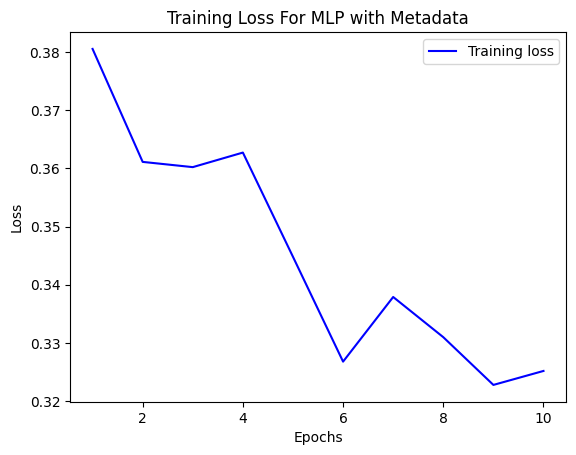

In [17]:
import matplotlib.pyplot as plt

def plot_loss_curve(loss_values):
    epochs = range(1, len(loss_values) + 1)
    plt.plot(epochs, loss_values, 'b', label='Training loss')
    plt.title('Training Loss For MLP with Metadata')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

#Plot
loss_values = [0.3805, 0.3611, 0.3602, 0.3627, 0.3448, 0.3268, 0.3379, 0.3310,0.3228, 0.3252]
plot_loss_curve(loss_values)

In [ ]:
#OLD TRAINING CODE
#---------------------------------------------------------------------
#Run Training
train_input = train_input.to(torch.float)
training_model = LogisticRegression(train_input.shape[1], 6)
training_model = training(train_input, labels, training_model)

Epoch [1/10], Loss: 0.4446
Epoch [2/10], Loss: 0.4752
Epoch [3/10], Loss: 0.4380
Epoch [4/10], Loss: 0.4802
Epoch [5/10], Loss: 0.4356
Epoch [6/10], Loss: 0.4218
Epoch [7/10], Loss: 0.3976
Epoch [8/10], Loss: 0.4355
Epoch [9/10], Loss: 0.4041
Epoch [10/10], Loss: 0.4321


In [ ]:
#Train Accuracy
model_outputs = torch.argmax(training_model(train_input.to('cpu')), axis =1)
argmax_labels = torch.argmax(torch.Tensor(labels), axis =1)
print(sum(model_outputs == argmax_labels)/len(model_outputs))

tensor(0.3313)


In [ ]:
#Validation Accuracy
val_model_outputs = torch.argmax(training_model(val_input.to('cpu')), axis =1)
argmax_val_labels = torch.argmax(torch.Tensor(val_labels), axis =1)
print(sum(val_model_outputs == argmax_val_labels)/len(val_model_outputs))

tensor(0.3357)
